In [1]:
%load_ext autoreload
%autoreload 2

# Create a basic optimization model

We'll build a minimal 24 hours dispatch $x$ model with a global CO2 constraint and optimized capacities $y$ and then split it up into multiple blocks and solve with PIPS-IPM++.

Minimize:
$$ c_y \cdot y + c_x \cdot x $$
      
subject to:

1. positive dispatch: $$ x_{k,t} \ge 0 \quad\forall k,\, t$$
2. capacities extendable to k: $$ 0 \le y_k \le k \quad\forall k$$
3. dispatch limited to capacity: $$ x_{k,t} \le y_k \quad\forall k,\, t $$
4. dispatch rate constrained to 1: $$ -1 \le x_{k,t} - x_{k,t-1} \le 1 \quad\forall k,\, t$$ 

5. demand satisfied: $$ \sum_k x_{k,t} = d_t \quad\forall t $$
6. global CO $_2$ limit: $$ \sum_{k,t} \frac{0.2 tCO_2/MWh}{0.45} x_{k,t} \le 10tCO_2 $$

The constraints have a diverse block structure, where *1,2,3* are local in t and k. *4* has a narrow band structure in t, and is local in k, *5* is local in t, but global in k and *6* is global.   


In [407]:
from linopy import Model
import numpy as np
import pandas as pd

In [408]:
m = Model()

We define `x` and `y` using the `add_variables` function, the coords arguments specifies the dimensions. This automatically creates optimization variables for all coordinates.

In [409]:
time = pd.Index(range(24), name='time')
plant = pd.Index(range(10), name='plant')

x = m.add_variables(lower=0, coords=[plant, time], name='x', )
y = m.add_variables(lower=0, coords=[plant], name='y')

We again write the constraints out using the syntax from above, while multiplying the rhs with `t`. Note that the coordinates from the lhs and the rhs have to match. 

*Note: In case lhs and rhs have different sets of coordinates, the constraint creation is broadcasted over all combinations of coordinates.*

In [411]:
demand = pd.Series(3 + np.sin(np.pi/24 * time), index=time)

m.add_constraints(y - 1*x, '>=', 0, name='capacity')
m.add_constraints((1*x).sum("plant"), '=', demand, name='demand')
m.add_constraints(((0.2 / 0.45) * x).sum(), "<=", 50, name="co2limit")

<xarray.DataArray ()>
array(264)
Attributes:
    name:     co2limit

In [412]:
import xarray as xr

In [428]:
c = m.constraints.chunk({"time": 8})
cvars = m.constraints_lhs_vars.chunk({"time": 8})
ccoeffs = m.constraints_lhs_coeffs.chunk({"time": 8})

In [537]:
def test(c, cv, cc):
    print("run")
    print("c", c)
    print("cv", cv)
    print("cc", cc)
    v = {}
    for n, da in c.items():
        if da.shape:
            v[f"{n}_index"] = xr.DataArray(np.arange(np.prod(da.shape), dtype=int).reshape(da.shape), da.coords, da.dims)
            v[f"{n}_block"] = xr.DataArray(np.arange(np.prod(da.shape), dtype=np.uint8).reshape(da.shape), da.coords, da.dims)
        else:
            v[f"{n}_index"] = xr.DataArray(np.array(0, dtype=int), {}, [])
            v[f"{n}_block"] = xr.DataArray(np.array(5, dtype=np.uint8), {}, [])
    return xr.Dataset(v)

In [544]:
c.chunks

Frozen(SortedKeysDict({'plant': (10,), 'time': (8, 8, 8)}))

In [517]:
v = {}
for n, da in c.items():
    v[f"c_{n}_index"] = xr.DataArray(np.empty(shape=da.shape, dtype=int), da.coords)
    v[f"c_{n}_block"] = xr.DataArray(np.empty(shape=da.shape, dtype=np.uint8), da.coords)
t = xr.Dataset(v).chunk(c.chunks)

In [538]:
ds = xr.map_blocks(test, c, args=(), template=t).compute()

runrunrun
c 

<xarray.Dataset>
Dimensions:   (plant: 10, time: 8)
Coordinates:
  * time      (time) int64 8 9 10 11 12 13 14 15
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (plant, time) int64 8 9 10 11 12 13 14 ... 226 227 228 229 230 231
    demand    (time) int64 248 249 250 251 252 253 254 255
    co2limit  int64 264c <xarray.Dataset>
Dimensions:   (plant: 10, time: 8)
Coordinates:
  * time      (time) int64 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (plant, time) int64 16 17 18 19 20 21 ... 234 235 236 237 238 239
    demand    (time) int64 256 257 258 259 260 261 262 263
    co2limit  int64 264c
cv <xarray.Dataset>
Dimensions:   (capacity_term: 2, co2limit_term: 240, demand_term: 10, plant: 10, time: 8)
Coordinates:
  * time      (time) int64 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: capacity_term, co2limit_term, demand_term
Dat

In [539]:
ds

<xarray.Dataset>
Dimensions:         (plant: 10, time: 24)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * plant           (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity_index  (plant, time) int64 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
    capacity_block  (plant, time) uint8 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
    demand_index    (time) int64 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7
    demand_block    (time) uint8 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7
    co2limit_index  int64 0
    co2limit_block  uint8 5

In [413]:
m.blocks = xr.Dataset({
    "y": xr.DataArray(0, [plant]),
    "general": xr.DataArray(np.repeat(np.arange(1, 4+1), 6), [time])
})

In [415]:
def best_uint(max_value):
    for t in (np.uint8, np.uint16, np.uint32, np.uint64):
        if max_value <= np.iinfo(t).max:
            return t

In [423]:
from linopy.pips import Constraints, PipsSerialiser

In [ ]:
PipsSerialiser.build_block_map(num_blocks, m.blocks, nu)

In [418]:
constraints = Constraints.from_model(m)

In [420]:
m.blocks

<xarray.Dataset>
Dimensions:  (plant: 10, time: 24)
Coordinates:
  * plant    (plant) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Data variables:
    y        (plant) int64 0 0 0 0 0 0 0 0 0 0
    general  (time) int64 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4

In [421]:
num_blocks = max(m.blocks.max().values()).item()+1

In [ ]:
Pi

In [422]:
constraints.inequalities.block_sizes(num_blocks, block_map)

TypeError: isinstance() arg 2 must be a type or tuple of types

In [406]:
constraints.equalities.block_sizes(num_blocks, block_map)

array([0, 6, 6, 6, 6, 0])

In [404]:
constraints.block_sizes(num_blocks, block_map)

array([ 0, 66, 66, 66, 66,  1])

In [393]:
indicator = constraints.block_indicator("capacity", num_blocks, block_map)

In [394]:
num_of_nonzero_blocks = indicator[1:].sum(axis=0)

In [396]:
onlyone_b = num_of_nonzero_blocks == 1


In [401]:
indicator[1:].shape

(4, 10, 24)

In [399]:
indicator[1:, onlyone_b].sum(axis=1)

array([60, 60, 60, 60])

In [373]:
sum(m.constraints.sizes.values())

34

In [389]:
c.sum(axis=(1, 2))

array([24, 18,  6,  0,  0])

In [352]:
c = np.zeros((num_blocks+1,) + cb.shape[1:], dtype=bool)
c[(cb.values,) + tuple(np.ogrid[tuple(slice(None, s) for s in cb.shape)][1:])] = True

In [354]:
c[1:]

array([[[ True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, False, False]],

       [[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])

In [297]:
num_blocks[cons_blocks.values] = 1

TypeError: 'int' object does not support item assignment

In [295]:
cons_blocks

<xarray.DataArray 'capacity' (capacity_term: 2, plant: 10, time: 24)>
array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]],
...
       [[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4],
        [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
         4, 4, 4]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant    (plant) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: capacity_term

In [267]:
cons_blocks.dims

('capacity_term', 'plant', 'time')

In [277]:
a = np.array([[0, 0, 1,3], [1,2,1,2]])

In [291]:
xr.apply_ufunc()

Signature:
xr.apply_ufunc(
    func: Callable,
    *args: Any,
    input_core_dims: Sequence[Sequence] = None,
    output_core_dims: Union[Sequence[Sequence], NoneType] = ((),),
    exclude_dims: AbstractSet = frozenset(),
    vectorize: bool = False,
    join: str = 'exact',
    dataset_join: str = 'exact',
    dataset_fill_value: object = <no-fill-value>,
    keep_attrs: Union[bool, str] = None,
    kwargs: Mapping = None,
    dask: str = 'forbidden',
    output_dtypes: Sequence = None,
    output_sizes: Mapping[Any, int] = None,
    meta: Any = None,
    dask_gufunc_kwargs: Dict[str, Any] = None,
) -> Any
Docstring:
Apply a vectorized function for unlabeled arrays on xarray objects.

The function will be mapped over the data variable(s) of the input
arguments using xarray's standard rules for labeled computation, including
alignment, broadcasting, looping over GroupBy/Dataset variables, and
merging of coordinates.

Parameters
----------
func : callable
    Function to call like ``fu

In [287]:
np.apply_along_axis(lambda f: np.unique(f, return_counts=True)[1][0], 0, a)

array([1, 1, 2, 1])

In [282]:
np.unique(a, axis=1, return_counts=True)

(array([[0, 0, 1, 3],
        [1, 2, 1, 2]]),
 array([1, 1, 1, 1]))

In [288]:
np.unique?

Signature:
np.unique(
    ar,
    return_index=False,
    return_inverse=False,
    return_counts=False,
    axis=None,
)
Docstring:
Find the unique elements of an array.

Returns the sorted unique elements of an array. There are three optional
outputs in addition to the unique elements:

* the indices of the input array that give the unique values
* the indices of the unique array that reconstruct the input array
* the number of times each unique value comes up in the input array

Parameters
----------
ar : array_like
    Input array. Unless `axis` is specified, this will be flattened if it
    is not already 1-D.
return_index : bool, optional
    If True, also return the indices of `ar` (along the specified axis,
    if provided, or in the flattened array) that result in the unique array.
return_inverse : bool, optional
    If True, also return the indices of the unique array (for the specified
    axis, if provided) that can be used to reconstruct `ar`.
return_counts : bool, optiona

Signature: np.lib.arraysetops.ediff1d(ary, to_end=None, to_begin=None)
Docstring:
The differences between consecutive elements of an array.

Parameters
----------
ary : array_like
    If necessary, will be flattened before the differences are taken.
to_end : array_like, optional
    Number(s) to append at the end of the returned differences.
to_begin : array_like, optional
    Number(s) to prepend at the beginning of the returned differences.

Returns
-------
ediff1d : ndarray
    The differences. Loosely, this is ``ary.flat[1:] - ary.flat[:-1]``.

See Also
--------
diff, gradient

Notes
-----
When applied to masked arrays, this function drops the mask information
if the `to_begin` and/or `to_end` parameters are used.

Examples
--------
>>> x = np.array([1, 2, 4, 7, 0])
>>> np.ediff1d(x)
array([ 1,  2,  3, -7])

>>> np.ediff1d(x, to_begin=-99, to_end=np.array([88, 99]))
array([-99,   1,   2, ...,  -7,  88,  99])

The returned array is always 1D.

>>> y = [[1, 2, 4], [1, 6, 24]]
>>> np.

In [271]:
np.unique(cons_blocks, return_counts=True, axis=0)

(array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0]],
 
        [[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 

In [243]:
da.apply_ufunc(lambda s: block_map.values[s.values])

array([[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4]])

In [ ]:
m.constraints_lhs_vars["demand"].map

When we add the objective, we use the `sum` function of `linopy.LinearExpression`. This stacks the `term_` dimension, such that all terms of the `time` dimension are rewritten into one big expression. 

In [68]:
obj = ((20 / 0.45 + 4)*x).sum() + (100*y).sum()
m.add_objective(obj)

Linear Expression with 250 term(s):
----------------------------------

Dimensions:  (_term: 250)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) float64 48.44 48.44 48.44 48.44 ... 100.0 100.0 100.0 100.0
    vars     (_term) int64 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249

In [103]:
    con = m.constraints
    coef = m.constraints_lhs_coeffs
    var = m.constraints_lhs_vars
    sign = m.constraints_sign
    rhs = m.constraints_rhs

In [104]:
from linopy.io import to_float_str, to_int_str, join_str_arrays

In [117]:
m.constraints_sign

<xarray.Dataset>
Dimensions:   ()
Data variables:
    capacity  <U2 '>='
    demand    <U1 '='
    co2limit  <U2 '<='

In [126]:
from toolz import pluck

In [129]:
from linopy.pips import index_map

In [134]:
max(m.variables.max().values()).item()

249

In [160]:
var_map, nvar = index_map(m.variables)

In [211]:
from toolz import groupby

In [ ]:
groupby(lambda s: s in ("=", "=="), )

In [208]:
[n for n, s in m.constraints_sign.items() if s in ("=", "==")]

['demand']

In [214]:
d= to_constraint_matrix(m)

In [218]:
d["ineq_hi"][0]

-9223372036854775808

In [209]:
m.constraints_rhs[['demand']]

<xarray.Dataset>
Dimensions:  (time: 24)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Data variables:
    demand   (time) float64 3.0 3.131 3.259 3.383 3.5 ... 3.5 3.383 3.259 3.131

In [206]:
m.constraints_sign == "="

ValueError: Dimensions {'co2limit', 'demand', 'capacity'} do not exist. Expected one or more of Frozen(SortedKeysDict({}))

In [204]:
m.constraints[.sel(m.constraints_sign == "=")

ValueError: dimensions or multi-index levels ['capacity', 'demand', 'co2limit'] do not exist

In [139]:
m.constraints_lhs_vars

<xarray.Dataset>
Dimensions:   (capacity_term: 2, co2limit_term: 240, demand_term: 10, plant: 10, time: 24)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: capacity_term, co2limit_term, demand_term
Data variables:
    capacity  (capacity_term, plant, time) int64 240 240 240 240 ... 237 238 239
    demand    (demand_term, time) int64 0 1 2 3 4 5 ... 234 235 236 237 238 239
    co2limit  (co2limit_term) int64 0 1 2 3 4 5 6 ... 234 235 236 237 238 239

In [193]:
n = "capacity"
con = m.constraints[n]
dims = con.dims + (f"{n}_term", )

cols = var_map[np.ravel(m.constraints_lhs_vars[n].transpose(*dims))]
data = np.ravel(m.constraints_lhs_coeffs[n].transpose(*dims))

nterms = m.constraints_lhs_vars.dims[f"{n}_term"]
indptr = np.arange(0, con.size * nterms + 1, nterms)

In [194]:
ma = csr_matrix((data, cols, indptr), shape=(con.size, nvar))

In [196]:
from linopy.pips import to_constraint_matrix

In [199]:
ma = to_constraint_matrix(m)

In [190]:
import matplotlib.pyplot as plt

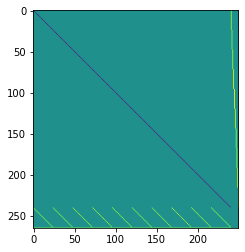

In [200]:
plt.imshow(np.array(ma.todense()))

In [142]:
v

<xarray.DataArray 'demand' (demand_term: 10, time: 24)>
array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
       [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
       [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
       [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
       [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191],
       [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215],
       [216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: demand_term
Attributes:
    name:     x

In [145]:
cf.transpose("time", "demand_term")

<xarray.DataArray 'demand' (time: 24, demand_term: 10)>
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: demand_term

In [128]:
list(pluck("size", m.variables.values()))

KeyError: 'size'

In [123]:
max(m.variables.max().values()).item()

249

In [105]:
    nonnans = coef.notnull() & var.notnull()
    join = [to_float_str(coef), " x", to_int_str(var), "\n"]
    lhs_str = join_str_arrays(join).where(nonnans, "").reduce(np.sum, [f"{n}_term" for n in con])
    # .sum() does not work
    

In [116]:
join_str_arrays(["c", to_int_str(con)])

<xarray.Dataset>
Dimensions:   (plant: 10, time: 24)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (plant, time) object 'c0' 'c1' 'c2' 'c3' ... 'c237' 'c238' 'c239'
    demand    (time) object 'c240' 'c241' 'c242' 'c243' ... 'c261' 'c262' 'c263'
    co2limit  <U4 'c264'

In [95]:
from linopy.solvers import run_gurobi

In [98]:
eval("run_gurobi + os.unlink('important_file')")

NameError: name 'os' is not defined

In [91]:
lhs_str

<xarray.Dataset>
Dimensions:   (plant: 10, time: 24)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (plant, time) object '+1.000000 x240\n-1.000000 x0\n' ... '+1.0...
    demand    (time) object '+1.000000 x0\n+1.000000 x24\n+1.000000 x48\n+1.0...
    co2limit  <U3490 '+0.444444 x0\n+0.444444 x1\n+0.444444 x2\n+0.444444 x3\...

In [ ]:
    nonnans = nonnans.any("_term") & con.notnull() & sign.notnull() & rhs.notnull()

    join = [
        "c",
        to_int_str(con),
        ": \n",

In [72]:
m.constraints

<xarray.Dataset>
Dimensions:   (plant: 10, time: 24)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (plant, time) int64 0 1 2 3 4 5 6 ... 233 234 235 236 237 238 239
    demand    (time) int64 240 241 242 243 244 245 ... 258 259 260 261 262 263
    co2limit  int64 264

In [75]:
m.constraints_lhs_coeffs.reduce?

Signature:
m.constraints_lhs_coeffs.reduce(
    func: Callable,
    dim: Union[Hashable, Iterable[Hashable]] = None,
    keep_attrs: bool = None,
    keepdims: bool = False,
    numeric_only: bool = False,
    **kwargs: Any,
) -> 'Dataset'
Docstring:
Reduce this dataset by applying `func` along some dimension(s).

Parameters
----------
func : callable
    Function which can be called in the form
    `f(x, axis=axis, **kwargs)` to return the result of reducing an
    np.ndarray over an integer valued axis.
dim : str or sequence of str, optional
    Dimension(s) over which to apply `func`.  By default `func` is
    applied over all dimensions.
keep_attrs : bool, optional
    If True, the dataset's attributes (`attrs`) will be copied from
    the original object to the new one.  If False (default), the new
    object will be returned without attributes.
keepdims : bool, default: False
    If True, the dimensions which are reduced are left in the result
    as dimensions of size one. Coord

In [71]:
m.objective.vars.isin(labels)

<xarray.DataArray 'vars' (_term: 250)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
Dimensions without coordinates: _term

In [109]:
m

Linopy model

Variables:
----------
Dimensions:  (plant: 10, time: 24)
Coordinates:
  * plant    (plant) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Data:
    x        (plant, time) int64 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
    y        (plant) int64 240 241 242 243 244 245 246 247 248 249

Constraints:
------------
Dimensions:   (plant: 10, time: 24)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * plant     (plant) int64 0 1 2 3 4 5 6 7 8 9
Data:
    capacity  (plant, time) int64 0 1 2 3 4 5 6 ... 233 234 235 236 237 238 239
    demand    (time) int64 240 241 242 243 244 245 ... 258 259 260 261 262 263
    co2limit  int64 264

Status:
-------
initialized

In [100]:
m.solve(solver_name='cbc');

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Oct 15 2020 

command line - cbc -printingOptions all -import /var/folders/7s/0xp34yc968q9tdgfl38mlg240000gp/T/linopy-problem-5y0lt8_8.lp -solve -solu /var/folders/7s/0xp34yc968q9tdgfl38mlg240000gp/T/linopy-solve-h04xd2ci.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 264 (-1) rows, 250 (0) columns and 720 (-240) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00097857488 ( 0.00097857488%) - largest zero change 0
0  Obj 0 Primal inf 87.257026 (24)
80  Obj 4227.1392 Primal inf 87.257026 (24)
160  Obj 4227.1436 Primal inf 87.257026 (24)
240  Obj 4627.143 Primal inf 1.953902 (15)
273  Obj 4627.143
Optimal - objective value 4627.1193
After Postsolve, objective 4627.1193, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 4627.119272 - 273 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01



<AxesSubplot:xlabel='plant,time', ylabel='Optimal Value'>

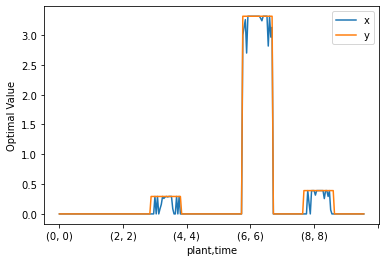

In [101]:
m.solution.to_dataframe().plot(ylabel='Optimal Value')

In [95]:
m.solution['x'].sum('plant')

<xarray.DataArray 'x' (time: 24)>
array([3.      , 3.130526, 3.258819, 3.382683, 3.5     , 3.608761,
       3.707107, 3.793353, 3.866025, 3.92388 , 3.965926, 3.991445,
       4.      , 3.991445, 3.965926, 3.92388 , 3.866025, 3.793353,
       3.707107, 3.608761, 3.5     , 3.382683, 3.258819, 3.130526])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

You can easily add dimensions in this way. Since the underlying code is highly relying on `xarray` broadcasting on new dimensions is automatically supported, so even the `rhs` can introduce new dimensions. Just be carefull that all variable dimensions have the correct dimension name. 

We limit the slope of the `y` variable by adding a constraint in the form of 
$$ y_{t} - y_{t-1} \le 0.5 \qquad \forall t \ge 1$$

In [19]:
lhs = (y - y.shift(time=1)).sel(time=time[1:])
m.add_constraints(lhs, '<=', 0.5, name='Limited growth y')

<xarray.DataArray (time: 9)>
array([20, 21, 22, 23, 24, 25, 26, 27, 28])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9
Attributes:
    name:     Limited growth y

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - cbc -printingOptions all -import /tmp/linopy-problem-i7hvv1nk.lp -solve -solu /tmp/linopy-solve-y4y26sce.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 27 (-2) rows, 19 (-1) columns and 54 (-4) elements
Perturbing problem by 0.001% of 2 - largest nonzero change 0.00022498367 ( 0.011249183%) - largest zero change 0
0  Obj 0 Primal inf 91.285696 (18)
19  Obj 141.59453
Optimal - objective value 141.58621
After Postsolve, objective 141.58621, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 141.5862069 - 19 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



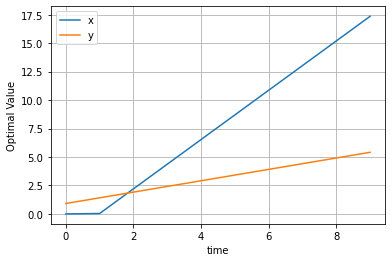

In [21]:
m.solve(solver_name='cbc')
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value');